# APS 3

___

####  <font style='font-family:Georgia' color='darkturquoise'> Arthur

### Importando bibliotecas e valores

In [144]:
from funcoesTermosol import *
import numpy as np
import math
from time import perf_counter

In [145]:
def matprint(mat, fmt="g"):        # Credits to braingineer https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

### Representação da estrutura

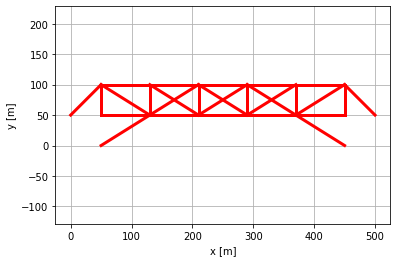

In [146]:
entrada = "entrada1.xlsx"

[nn,N,nm,Inc,nc,F,nr,R] = importa(entrada)

plota(N, Inc)
# geraSaida()

### Informações sobre a treliça

* nn: número de nós
* N: Matriz dos nós
* nm: número de membros
* Inc: Matriz de incidência. Colunas:
    1. Nó 1
    2. Nó 2
    3. E
    4. A
* nc: número de cargas
* F: forças (Vetor carregamento)
* nr: número de restrições
* R: Restrições (Vetor com os graus de liberdade)

In [147]:
# Comprimento 
L = 4
#numero de nodes
n = 8

### Gerando a matriz de conectividade transposta

In [148]:
C = []
for i in range(nm):
        C_i = nn*[0]

        no_1 = int(Inc[i, 0])
        no_2 = int(Inc[i, 1])

        C_i[no_1-1] = -1
        C_i[no_2-1] = 1
        C.append(C_i) 

C_t = np.array(C).T
matprint(C_t)

 0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  
-1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  -1   0   0   0   0   0   0   0   0  
 1  -1   0   0   0   0   0   0   0   0   0   1  -1   0   0   0   0   1   0   0   1   0   0   0   0   0   0   0  
 0   1  -1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0  -1  -1   0  
 0   0   1  -1   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   1   0   0   0   0  -1  
 0   0   0   1  -1   0   0   0   0   0   0   0   0   0   1  -1   0   0  -1   0   0   0   0   1   0   0   0   0  
 0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0  
 0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0  
 0   0   0   0   0  -1   0   0   0   0   1  -1   0   0   0   0   0   0   0   1   0   0   0   0  

### Matriz dos membros (M)

In [149]:
M = np.matmul(N, C_t)
print(M)

[[ 80.  80.  80.  80.  80.  80.  80.  80.  80.  80.  50.  80.  80.  80.
   80.  80.  50.  80.  80.   0.   0.   0.   0.   0.   0.  80. -80.  80.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  50. -50.  50. -50.
  -50.  50. -50.  50. -50.  50. -50. -50. -50. -50. -50.  50.  50.  50.]]


### Obtendo Se, Ke e Kg

In [150]:
len_linhas_M = len(M)
len_linhas_C = len(C_t)
Kg = np.zeros((nn*2, nn*2))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    
    n1 = Inc[i,0]
    n2 = Inc[i,1]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))
    
    const = E*A/L
    
    M_aux = M[:,i]
    M_aux.shape = [len_linhas_M, 1]
    M_aux2 = np.transpose(M_aux)
    Se = (const * np.matmul(M_aux, M_aux2)) / (np.linalg.norm(M[:,i])**2)

    C_aux = C_t[:,i]
    C_aux.shape = [len_linhas_C, 1]
    C_aux2 = np.transpose(C_aux)
    
    multi_C_aux = np.matmul(C_aux, C_aux2)
    Ke = np.kron(multi_C_aux, Se)
    Kg += Ke
# print(Se)
print(Kg)

[[ 16970.56274848  16970.56274848      0.         ...      0.
       0.              0.        ]
 [ 16970.56274848  16970.56274848      0.         ...      0.
       0.              0.        ]
 [     0.              0.          30000.         ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ...   7146.05312364
       0.              0.        ]
 [     0.              0.              0.         ...      0.
   18293.89599651 -11433.68499782]
 [     0.              0.              0.         ...      0.
  -11433.68499782   7146.05312364]]


### Deslocamento nodal

Aplicando as condições de contorno para a matriz das forças:

In [151]:
F_c = np.delete(F, R.astype(int))
F_c


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., 75.,  0., 75.,  0.,  0.,  0.,  0.])

Aplicando as condições de contorno para a matriz da rigidez:

In [152]:
Kg_c = np.delete(Kg, R.astype(int),0)
Kg_c = np.delete(Kg_c, R.astype(int), 1)
matprint(Kg_c)

 30000    -30000         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0         0  
-30000    114882   11433.7    -30000         0         0         0         0         0         0  -18293.9   11433.7         0         0  -18293.9  -11433.7         0         0         0         0         0         0  
     0   11433.7   69438.2         0         0         0         0         0         0         0   11433.7  -7146.05         0    -48000  -11433.7  -7146.05         0         0         0         0         0         0  
     0    -30000         0   96587.8         0    -30000         0         0         0         0         0         0  -18293.9   11433.7         0         0  -18293.9  -11433.7         0         0         0         0  
     0         0         0         0   62292.1         0         0         0         0         0         0         0   11433

___
**Funções de Jacobi e Gauss-Seidel utilizadas na aula 21:**

In [153]:
# def jacobi(k,F,ite,tol):
#     #inicializando X com 
#     x = np.zeros(k.shape[0])

#     # Cria um vetor com os elementos da diagonal de k                       
#     diagonal = np.diag(k)
#     # Subtrai a diagonal de K
#     k_d = k - np.diagflat(diagonal)
#     # loop até chegar abaixo da tolerância ou passar do número máximo de iterações
#     for i in range(ite):
#         x2 = (F - np.matmul(k_d,x)) / diagonal
#         error =  max(abs((x2 - x)/x2) )
#         if error < tol:
#             print(f"Erro máximo: {error}")
#             print(f"Convergiu na iteração: {i}")
#             return x2
        
#         x = x2
#     return x
def jacobi(K,F,ite,tol):
    if type(K) != list:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    else:
        U = np.zeros((len(K),1))
        n = len(K)
    U_ = U.copy()
    count = 0
    while count < ite:
        for i in range(n):
            U_[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_[i][0] -= K[i][j] * U[j][0]
            U_[i][0] /= K[i][i]

        if 0 not in U:     # Cálculo do erro
            ERROR_list = []
            for i,j in zip(U_,U):
                ERROR_list.append(abs((i-j)/j))
            ERRO = max(ERROR_list)
            if ERRO < tol:
                print("Iterações: {0}".format(count))
                return U;
        U = U_.copy() 
        count += 1
    print("Iterações: {0}".format(count))
    return U;

In [154]:
# def gauss_seidel(A, b, ite, tol):
#     x = np.zeros_like(b, dtype=np.double)
    
#     #Iterate
#     for k in range(ite):
        
#         x_old  = x.copy()
        
#         #Loop over rows
#         for i in range(A.shape[0]):
#             x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
            
#         #Stop condition 
#         if np.linalg.norm(x - x_old, ord=np.inf) / np.linalg.norm(x, ord=np.inf) < tol:
#             break
            
#     return x
def gauss_seidel(K,F,ite,tol):
    if type(K) != list:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    else:
        U = np.zeros((len(K),1))
        n = len(K)
    U_ = U.copy()
    count = 0
    while count < ite:
        for i in range(n):
            U_[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_[i][0] -= K[i][j] * U_[j][0]
            U_[i][0] /= K[i][i]

        if 0 not in U:     # Cálculo do erro
            ERROR_list = []
            for i,j in zip(U_,U):
                ERROR_list.append(abs((i-j)/j))
            ERRO = max(ERROR_list)
            if ERRO < tol:
                print("Iterações: {0}".format(count))
                return U;
        U = U_.copy() 
        count += 1
    print("Iterações: {0}".format(count))
    return U;

___
Utilizando Jacobi, Gauss-Seidel e a forma geral para cálculo da matriz **U**

In [155]:
u_jacobi = jacobi(Kg_c, F_c, 1000, 1e-5)
print("Método Jacobi:")
timer_start = perf_counter()
matprint(jacobi(Kg_c, F_c,1000, 1e-5))
print("Tempo: {0}".format(perf_counter() - timer_start))

Iterações: 1000
Método Jacobi:
Iterações: 1000
-3.75294e+21  
 3.98452e+21  
 6.36399e+21  
-4.39125e+21  
 4.63922e+21  
 3.99449e+21  
 3.98842e+21  
-2.79175e+21  
 5.39718e+21  
-3.99165e+21  
-2.18289e+21  
-1.56806e+20  
 5.00863e+21  
-7.61927e+21  
-4.34544e+21  
-4.48392e+21  
 4.07422e+21  
-3.70263e+21  
-4.91226e+21  
-6.65091e+21  
 3.04611e+21  
-1.19184e+21  
Tempo: 0.5844403759983834


In [156]:
u_gauss = gauss_seidel(Kg_c, F_c, 1000, 1e-5)
print("Método Gauss-Seidel:")
timer_start = perf_counter()
matprint(gauss_seidel(Kg_c, F_c, 1000, 1e-5))
print("Tempo: {0}".format(perf_counter() - timer_start))

Iterações: 221
Método Gauss-Seidel:
Iterações: 221
  0.00151658  
  0.00151659  
  0.00741168  
  0.00197854  
    0.018351  
 0.000232485  
   0.0190838  
 0.000219301  
  0.00888475  
  0.00462417  
 -0.00190693  
 0.000640387  
 -0.00213035  
  0.00797733  
-0.000905709  
   0.0186198  
  0.00259628  
   0.0193566  
  0.00431662  
   0.0093596  
  0.00482134  
 0.000197162  
Tempo: 0.1297821079933783


**Deslocamentos nodais**

In [157]:
U_ar = np.linalg.solve(Kg_c, F_c)
U_ar

array([ 0.00151664,  0.00151664,  0.00741185,  0.00197861,  0.01835142,
        0.00023253,  0.01908424,  0.00021934,  0.00888501,  0.00462433,
       -0.00190696,  0.0006404 , -0.00213037,  0.00797751, -0.0009057 ,
        0.01862022,  0.00259636,  0.01935705,  0.00431675,  0.00935986,
        0.0048215 ,  0.00019717])

**Ajustando o tamanho das matrizes U**

In [158]:
u_jacobi_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_jacobi_ajustado)):
    if e not in R:
        u_jacobi_ajustado[e] += u_jacobi[i]
        i += 1
u_jacobi_ajustado

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-3.75294260e+21],
       [ 0.00000000e+00],
       [ 3.98451581e+21],
       [ 6.36399131e+21],
       [-4.39125203e+21],
       [ 4.63921995e+21],
       [ 3.99449494e+21],
       [ 3.98841978e+21],
       [-2.79174944e+21],
       [ 5.39717893e+21],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-3.99164778e+21],
       [ 0.00000000e+00],
       [-2.18288683e+21],
       [-1.56806097e+20],
       [ 5.00863280e+21],
       [-7.61926711e+21],
       [-4.34543642e+21],
       [-4.48391512e+21],
       [ 4.07422475e+21],
       [-3.70263245e+21],
       [-4.91226289e+21],
       [-6.65091427e+21],
       [ 3.04611092e+21],
       [-1.19183924e+21],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [159]:
u_gauss_ajustado = np.zeros((nn*2,1))
i = 0
for e in range(len(u_gauss_ajustado)):
    if e not in R:
        u_gauss_ajustado[e] += u_gauss[i]
        i += 1
u_gauss_ajustado

array([[ 0.        ],
       [ 0.        ],
       [ 0.00151658],
       [ 0.        ],
       [ 0.00151659],
       [ 0.00741168],
       [ 0.00197854],
       [ 0.01835103],
       [ 0.00023249],
       [ 0.0190838 ],
       [ 0.0002193 ],
       [ 0.00888475],
       [ 0.        ],
       [ 0.        ],
       [ 0.00462417],
       [ 0.        ],
       [-0.00190693],
       [ 0.00064039],
       [-0.00213035],
       [ 0.00797733],
       [-0.00090571],
       [ 0.01861984],
       [ 0.00259628],
       [ 0.01935663],
       [ 0.00431662],
       [ 0.0093596 ],
       [ 0.00482134],
       [ 0.00019716],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [160]:
u = np.zeros((nn*2,1))
i = 0
for e in range(len(u)):
    if e not in R:
        u[e] += U_ar[i]
        i += 1
u

array([[ 0.        ],
       [ 0.        ],
       [ 0.00151664],
       [ 0.        ],
       [ 0.00151664],
       [ 0.00741185],
       [ 0.00197861],
       [ 0.01835142],
       [ 0.00023253],
       [ 0.01908424],
       [ 0.00021934],
       [ 0.00888501],
       [ 0.        ],
       [ 0.        ],
       [ 0.00462433],
       [ 0.        ],
       [-0.00190696],
       [ 0.0006404 ],
       [-0.00213037],
       [ 0.00797751],
       [-0.0009057 ],
       [ 0.01862022],
       [ 0.00259636],
       [ 0.01935705],
       [ 0.00431675],
       [ 0.00935986],
       [ 0.0048215 ],
       [ 0.00019717],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

### Reações de apoio

In [161]:
P = np.matmul(Kg,u)
P

array([[ 2.14942392e+01],
       [ 2.14942392e+01],
       [ 0.00000000e+00],
       [-3.07390626e+01],
       [ 1.42108547e-14],
       [ 1.77635684e-14],
       [-2.84217094e-14],
       [-2.84217094e-14],
       [ 5.68434189e-14],
       [ 1.70530257e-13],
       [-1.42108547e-14],
       [ 2.13162821e-14],
       [-6.58010539e+00],
       [-9.46406384e+00],
       [ 5.77315973e-15],
       [-5.77315973e-15],
       [-2.84217094e-14],
       [ 4.44089210e-15],
       [ 2.84217094e-14],
       [-2.13162821e-14],
       [-2.84217094e-14],
       [ 7.50000000e+01],
       [ 2.84217094e-14],
       [ 7.50000000e+01],
       [-5.68434189e-14],
       [-4.26325641e-14],
       [-1.42108547e-14],
       [ 2.13162821e-14],
       [-1.12489957e+02],
       [-7.03062231e+01],
       [ 9.75758233e+01],
       [-6.09848895e+01]])

In [162]:
P_r = np.zeros((nr,1))
for i in range(nr):  
    index = int(R[i])
    P_r[i] = P[index]    
P_r

array([[ 2.14942392e+01],
       [ 2.14942392e+01],
       [-3.07390626e+01],
       [-1.12489957e+02],
       [-7.03062231e+01],
       [-6.58010539e+00],
       [-9.46406384e+00],
       [-5.77315973e-15],
       [ 9.75758233e+01],
       [-6.09848895e+01]])

### Deformações, Tenões e Forças internas

In [163]:
deformacoes=[]
tensoes=[]
forcas=[]
for i in range (nm):
        
    matriz = [
            u[(int(Inc[i, 0])-1)*2], 
            u[(int(Inc[i, 0])-1)*2 +1], 
            u[(int(Inc[i, 1])-1)*2], 
            u[int(Inc[i, 1]-1)*2 +1]
    ]
    
    x1 = N[0][int(Inc[:,0][i])-1]
    y1 = N[1][int(Inc[:,0][i])-1]
    x2 = N[0][int(Inc[:,1][i])-1]
    y2 = N[1][int(Inc[:,1][i])-1]    
    
    L = math.sqrt(((x1-x2)**2+(y1-y2)**2))  
    
    E =  Inc[i, 2]
    A = Inc[i,3]
    const = E*A/L
    
    s = (y2-y1)/L
    c = (x2-x1)/L
    
    C = [-c, -s, c, s]

    deformacao = (1/L) * np.matmul(C, matriz)
    tensao = deformacao*E
    forca=tensao*A
    
    deformacoes.append(deformacao)
    tensoes.append(tensao)
    forcas.append(forca)



In [164]:
deformacoes

[array([0.]),
 array([5.77469072e-06]),
 array([-2.18260117e-05]),
 array([-1.64952218e-07]),
 array([-2.74171058e-06]),
 array([-2.79271734e-06]),
 array([1.53084047e-05]),
 array([4.37757644e-05]),
 array([2.1504886e-05]),
 array([6.30937589e-06]),
 array([-1.26656019e-05]),
 array([-7.26795751e-06]),
 array([4.11945506e-05]),
 array([7.62448379e-06]),
 array([3.74652386e-05]),
 array([-7.44031664e-06]),
 array([0.]),
 array([5.52722986e-05]),
 array([4.79441914e-05]),
 array([1.28079428e-05]),
 array([1.13132013e-05]),
 array([5.3759635e-06]),
 array([5.45622551e-06]),
 array([9.49719384e-06]),
 array([3.94335993e-06]),
 array([1.12023578e-05]),
 array([-2.13457054e-05]),
 array([-1.79192695e-05])]

In [165]:
tensoes

[array([0.]),
 array([23098.7628645]),
 array([-87304.04674908]),
 array([-659.80887288]),
 array([-10966.84232167]),
 array([-11170.86935411]),
 array([61233.61865911]),
 array([175103.05765964]),
 array([86019.54414995]),
 array([25237.50356705]),
 array([-50662.40754806]),
 array([-29071.83004721]),
 array([164778.20254343]),
 array([30497.93516231]),
 array([149860.95433191]),
 array([-29761.26655897]),
 array([0.]),
 array([221089.19422033]),
 array([191776.76577631]),
 array([51231.77103745]),
 array([45252.80500826]),
 array([21503.85400804]),
 array([21824.902056]),
 array([37988.77536431]),
 array([15773.43972941]),
 array([44809.43112844]),
 array([-85382.82172412]),
 array([-71677.07800337])]

In [166]:
forcas

[array([0.]),
 array([13.85925772]),
 array([-52.38242805]),
 array([-0.39588532]),
 array([-6.58010539]),
 array([-6.70252161]),
 array([36.7401712]),
 array([105.0618346]),
 array([51.61172649]),
 array([15.14250214]),
 array([-30.39744453]),
 array([-17.44309803]),
 array([98.86692153]),
 array([18.2987611]),
 array([89.9165726]),
 array([-17.85675994]),
 array([0.]),
 array([132.65351653]),
 array([115.06605947]),
 array([30.73906262]),
 array([27.151683]),
 array([12.9023124]),
 array([13.09494123]),
 array([22.79326522]),
 array([9.46406384]),
 array([26.88565868]),
 array([-51.22969303]),
 array([-43.0062468])]

___
**Gerando Saídas com as 3 matrizes U calculadas anteriormente**

In [167]:
x = geraSaida("geral", P_r, u, deformacoes, forcas, tensoes)

In [168]:
geraSaida("jacobi", P_r, u_jacobi_ajustado, deformacoes, forcas, tensoes)

In [169]:
geraSaida("gauss", P_r, u_gauss_ajustado, deformacoes, forcas, tensoes)